In [52]:
import torch
import xarray as xr
import mlpost_morocco as mlpost
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import torch
torch.cuda.is_available()


True

In [3]:
moroccan_locations = {
    "s_sahara": {"Lat": 26.125, "Lon": -13.125},
    "s_sahara_coast": {"Lat": 26.375, "Lon": -12.625},
    "laayoune_area": {"Lat": 26.625, "Lon": -12.375},
    "w_sahara_interior": {"Lat": 26.875, "Lon": -12.125},
    "s_morocco_border": {"Lat": 27.125, "Lon": -11.875},
    "dakhla": {"Lat": 23.875, "Lon": -15.625},
    "dakhla_coast": {"Lat": 24.125, "Lon": -15.375},
    "tarfaya": {"Lat": 27.875, "Lon": -11.375},
    "tan_tan_coast": {"Lat": 28.125, "Lon": -11.125},
    "s_interior": {"Lat": 29.125, "Lon": -9.875},
    "tiznit": {"Lat": 29.375, "Lon": -9.625},
    "agadir_coast": {"Lat": 30.125, "Lon": -9.125},
    "essaouira": {"Lat": 31.125, "Lon": -8.125},
    "el_jadida": {"Lat": 32.125, "Lon": -7.125},
    "casablanca": {"Lat": 33.125, "Lon": -6.125},
    "rabat": {"Lat": 34.125, "Lon": -5.125},
    "tangier": {"Lat": 35.125, "Lon": -4.125},
    "n_coast": {"Lat": 36.125, "Lon": -3.125},
    "n_tip": {"Lat": 37.125, "Lon": -2.125}
}


# Data Preprocessing Class

Could benefit from lots of cleaning up and cutting away

In [4]:
class precip_postprocessing:

    def __init__(self, model, scaler = None):
        self.model = model
        if scaler:
            self.scaler = scaler

    def load_data(self, observed_fp, predicted_fp, verbose = False): #Loading from the file path
        self.observed_data = xr.open_dataset(observed_fp)
        self.predicted_data = xr.open_dataset(predicted_fp)
        if verbose:
            print(f'CHIRPS NetCDF File: \n{self.observed_data}')
            print(f'NWP NetCDF File: \n{self.predicted_data}')
        print('DATA LOADED SUCCESSFULLY')

    def load_model(self, model):
        self.model = model

    def load_scaler(self, scaler):
        self.scaler = scaler

    def preprocess(self, lead_no): #Must require load_data first
        self.observed = self.observed_data.to_dataframe().reset_index()
        self.predicted = self.predicted_data.to_dataframe().reset_index()
        self.predicted = (
            self.predicted
            .groupby(['Time', 'Lead', 'Lat', 'Lon'])['TP'] #Finding average TP value for all ensembles
            .mean()
            .reset_index()
            .where(self.predicted['Lead']==lead_no)
            .dropna()
            .drop(columns=['Lead'])
            .rename(columns={"TP": "Predicted_TP"})
        )

        self.merged = (
            pd.merge(self.observed, self.predicted, on=['Time', 'Lat', 'Lon'], how = 'left') # <---- THIS IS SPECIFIC TO THIS USE CASE ---- not universal bc of feature names
            .dropna()
         )
        
    def split_by_locations(self, feature_array, target_var):
        self._train = self.merged[self.merged['Location'] == 'none']
        self.X_train = self._train[feature_array].to_numpy()
        self.y_train = self._train[target_var].to_numpy()

        self._test = self.merged[self.merged['Location'] != 'none']

        self.X_test = self._test[feature_array].to_numpy()
        self.y_test = self._test[target_var].to_numpy()

    def add_month_column(self): #Must require preprocess done first.. find 
        self.merged['Month'] = self.merged['Time']%100

    def merge_location_dict(self, d):
        self.location_dict = pd.DataFrame(d).T.reset_index()
        self.merged = (
            self.merged
            .merge(self.location_dict, on=['Lat', 'Lon'], how='left')
            .rename(columns={'index':'Location'})
            .fillna('none')
        )

    def train(self):
        print("BEGINNING TRAINING")
        self.model.fit(self.X_train, self.y_train)
    
    def evaluate(self):
        self.eval_preds = self.model.predict(self.X_test)
        print(f'RMSE: {rmse(self.y_test, self.eval_preds)}')
        print(f'MAE: {mae(self.y_test, self.eval_preds)}')

    def plot_region(self, region):
        self._test['ML_Preds'] = self.eval_preds
        df = self._test[self._test['Location'] == region]
        df.loc[:, ['TP', 'Predicted_TP', 'ML_Preds']].plot()

    def confidence_interval_rf(self, n):
        y_pred_all = []

        for i in range(n):
            print(f"TRAINING RF {i}")

            indices = np.random.choice(np.arange(self.X_train.shape[0]), size=self.X_train.shape[0], replace=True)
            X_boot = self.X_train[indices]
            y_boot = self.y_train[indices]

            rf = RandomForestRegressor()
            rf.fit(X_boot, y_boot)

            y_pred = rf.predict(self.X_test)
            y_pred_all.append(y_pred)

        # Calculate confidence intervals
        self.y_pred_all = np.array(y_pred_all).mean(axis=0)
        self.y_lower = np.percentile(y_pred_all, 2.5, axis=0)
        self.y_upper = np.percentile(y_pred_all, 97.5, axis=0)

        self._test['boot_rf'] = self.y_pred_all
        self._test['upper_ci'] = self.y_upper
        self._test['lower_ci'] = self.y_lower

    def plot_ci(self, region):
        df = self._test[self._test['Location'] == region]
        df.loc[:, ['TP', 'boot_rf', 'upper_ci', 'lower_ci']].plot()

    def run(self):
        self.load_data(
            '../data/raw/CHIRPS_1991_2021_MOR.nc',
            '../data/raw/RAW_CFSv2_1991_2020_MOR.nc',
            verbose=False
        )
        self.preprocess(3)
        self.add_month_column()
        self.merge_location_dict(moroccan_locations)
        self.split_by_locations(['Lat', 'Lon', 'Month', 'Predicted_TP'], 'TP')
        self.train()
        self.evaluate()

### Loading in data

Maybe remove need to establish model in class initialization

In [5]:
post_processor = precip_postprocessing(None)

In [6]:
post_processor.load_data(
    '../data/chirps_data.nc',
    '../data/raw_precip_preds.nc',
    verbose=False
)
post_processor.preprocess(3)
post_processor.add_month_column()

DATA LOADED SUCCESSFULLY


In [7]:
unique_times = post_processor.merged['Time'].unique()
unique_times.sort()

In [8]:
arr = []
tmp = post_processor.merged[['Lat', 'Lon', 'TP','Time']]

for i in tmp['Time'].unique():
    df_tmp = tmp[tmp['Time'] == i]
    df_tmp = df_tmp.pivot(index='Lat', columns='Lon', values='TP')
    arr.append(df_tmp.to_numpy())

arr = np.array(arr)
arr = torch.from_numpy(arr)

In [9]:
arr = arr.reshape([30, 1, 74, 87])

## Running NN

In [10]:
import Network
from sklearn.preprocessing import StandardScaler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.cuda.empty_cache()

network = Network.Generator(in_channels=1) 

output = network(arr)

output_viz = output.detach().numpy()

## Visualizations

In [49]:
time_arr = np.array(tmp['Time'].unique())
time_slice = 13

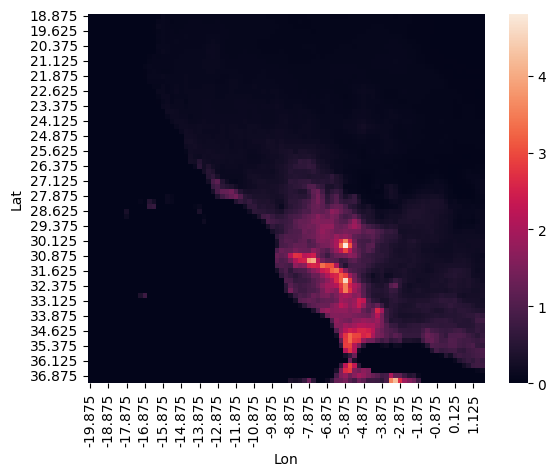

In [53]:
df_tmp = tmp[tmp['Time'] == time_arr[time_slice]]
df_tmp = df_tmp.pivot(index='Lat', columns='Lon', values='TP')

sns.heatmap(df_tmp)
plt.savefig("../images/pre_precip.png")

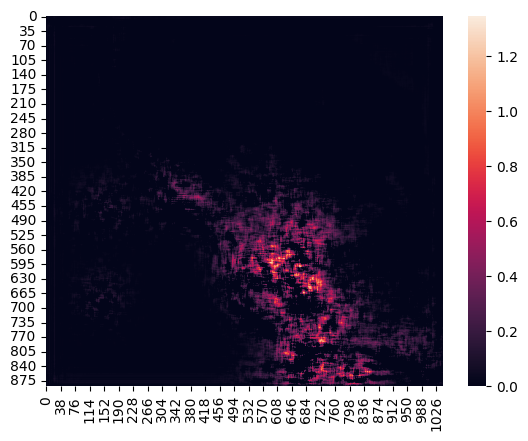

In [54]:
sns.heatmap(output_viz[time_slice][0], vmin=0)
plt.savefig("../images/post_precip.png")